<img src="https://cdn.prod.website-files.com/63f902d79a33f71d496cde07/65287da434fc7c58e87cdcc9_Opengraph-Image.jpg" align="center" width="400"/>

## 1. Install And Import Libreries

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!ls /content/drive/MyDrive/Colab_Notebooks/rootstrap/

3.0-yolov8-final-detection.ipynb  requirements.txt  yolo11n.pt
data-yolo			  runs		    yolov8n.pt


In [5]:
cd /content/drive/MyDrive/Colab_Notebooks/rootstrap/

/content/drive/MyDrive/Colab_Notebooks/rootstrap


In [6]:
# !pip install -r requirements.txt
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 27.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 121.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 99.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 65.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 114.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalli

In [21]:
# pip install Pillow==9.5.0 --force-reinstall


> 💡 **Justification for Using YOLO**
>
> YOLO was chosen over a traditional classifier like ResNet because:
>
> 1. ResNet is better to predict one class per image.
> 2. YOLO uses bounding box annotations already available in `.txt` files.
> 3. YOLO can detect several ships of different classes in the same image.
>
> This makes YOLO a better fit for the dataset’s structure and the task’s needs.


In [1]:
import pandas as pd
import numpy as np
import math
import gc
import os
from glob import glob
import yaml
import random

# Data Visualization Libraries
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
%matplotlib inline
sns.set()

# Manipulation
from collections import defaultdict

# Vision
from PIL import UnidentifiedImageError, Image, ImageFilter
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, WeightedRandomSampler
from collections import Counter
import torchvision.transforms.functional as F
from torchvision.transforms.functional import to_pil_image
import cv2

# Model
from tqdm import tqdm  # para mostrar progreso
import torch
import torch.nn as nn
from torchvision import models
import torch.optim as optim
from torch.utils.data import Dataset
from ultralytics import YOLO

# Order pictures
import os
import shutil

# Metrics
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, confusion_matrix, multilabel_confusion_matrix

device = 'cuda'

## 2. EDA - Exploratory Data Analysis

### 2.1 Load CSV files containing the labels

In [23]:
### Directories

train_dir = '/content/drive/MyDrive/Colab_Notebooks/rootstrap/data-yolo/train/images' # TRAIN
val_dir = '/content/drive/MyDrive/Colab_Notebooks/rootstrap/data-yolo/valid/images' # VAL
test_dir = '/content/drive/MyDrive/Colab_Notebooks/rootstrap/data-yolo/test/images' # TEST

In [24]:
### Load class names from YAML file

with open('data-yolo/data.yaml', 'r') as f:
    data_yaml = yaml.safe_load(f)

class_names = data_yaml['names']
class_names

['Fishing Boat',
 'Merchant Ship',
 'Military Ship',
 'Patrol Boat',
 'Sails Boat',
 'Submarine',
 'Tugboat',
 'Yacht']

In [2]:
### Upload and counts image and label files for each dataset split.

base_dir = 'data-yolo'

splits = ['train', 'valid', 'test']

# Get sorted lists of image and label paths for each split
image_paths = {split: sorted(glob(os.path.join(base_dir, split, 'images', '*.jpg'))) for split in splits}
label_paths = {split: sorted(glob(os.path.join(base_dir, split, 'labels', '*.txt'))) for split in splits}

# Check the number of images and labels for each split
for split in splits:
    print(f"{split.upper()}: {len(image_paths[split])} images, {len(label_paths[split])} labels")

TRAIN: 530 images, 530 labels
VALID: 139 images, 139 labels
TEST: 67 images, 67 labels


In [8]:
# Ruta a la carpeta de labels
labels_dir = 'data-yolo/train/labels'  # Cambiar a tu path real

# Lista de nombres de clase
class_names = data_yaml['names']  # Ya lo tenés definido

# Inicializar contador
box_counts = Counter()

# Contar boxes por clase
for filename in os.listdir(labels_dir):
    if filename.endswith('.txt'):
        with open(os.path.join(labels_dir, filename), 'r') as f:
            for line in f:
                class_id = int(line.strip().split()[0])
                box_counts[class_id] += 1

# Mostrar resultados con nombres
print("Bounding boxes per class:\n")
for class_id, count in sorted(box_counts.items()):
    class_name = class_names[class_id] if class_id < len(class_names) else f"Unknown_{class_id}"
    print(f"{class_name} ({class_id}): {count} boxes")

Bounding boxes per class:

Fishing Boat (0): 308 boxes
Merchant Ship (1): 335 boxes
Military Ship (2): 350 boxes
Patrol Boat (3): 339 boxes
Sails Boat (4): 354 boxes
Submarine (5): 292 boxes
Tugboat (6): 42 boxes
Yacht (7): 334 boxes


### 2.2 Convert to Tensors

In [30]:
### Read YOLO label files and turns them into tensors,
### grouped by train, valid, and test sets, to use in object detection.

parsed_labels = {}  # Dictionary to store parsed label tensors for each split

for split in splits:
    print(f"\n📁 Processing split: {split}")
    split_labels = []  # List to hold label tensors for the current split

    for idx, label_file in enumerate(label_paths[split]):
        print(f"  📄 Reading file {idx + 1}/{len(label_paths[split])}: {label_file}")
        try:
            with open(label_file, 'r') as f:
                lines = f.read().strip().split('\n')  # Read all lines and split by newline

                # Convert each line into a list of floats: [class_id, x_center, y_center, width, height]
                boxes = [list(map(float, line.split())) for line in lines if line]

                # Convert to PyTorch tensor and append to the list
                split_labels.append(torch.tensor(boxes, device=device))  # Shape: [num_objects, 5]
        except Exception as e:
            print(f"  ❌ Error reading file: {e}")
            split_labels.append(torch.empty((0, 5)))  # Optional: placeholder on error

    # Store the list of label tensors in dictionary
    parsed_labels[split] = split_labels

# Print FIRST example
print("\n✅ First parsed label tensor from 'train':")
print(parsed_labels['train'][0])



📁 Processing split: train
  📄 Reading file 1/530: data-yolo/train/labels/fish_42_jpg.rf.c398a765749e4e659f8504abba3059b6.txt
  📄 Reading file 2/530: data-yolo/train/labels/fish_51_jpg.rf.46840b82dc80129006d1f247f47c60fd.txt
  📄 Reading file 3/530: data-yolo/train/labels/fish_66_jpg.rf.09accb4cf8ba4ed1d1b9c472cda60aba.txt
  📄 Reading file 4/530: data-yolo/train/labels/fish_68_jpg.rf.14091b46409d47a4492ebe18f1717829.txt
  📄 Reading file 5/530: data-yolo/train/labels/fish_73_jpg.rf.8f9e1c121111a11c297e531598c25c2a.txt
  📄 Reading file 6/530: data-yolo/train/labels/fish_84_jpg.rf.d285368be87be86d1a43811a3274e3b8.txt
  📄 Reading file 7/530: data-yolo/train/labels/fish_92_jpg.rf.5ef1159e274c4df314b97e45d1c96460.txt
  📄 Reading file 8/530: data-yolo/train/labels/merch_34_jpg.rf.96b4ba38de5ca6c125a92fd3f203f26b.txt
  📄 Reading file 9/530: data-yolo/train/labels/merch_41_jpg.rf.223dbd557f75b90ab65a389d9664946d.txt
  📄 Reading file 10/530: data-yolo/train/labels/merch_41_jpg.rf.68e881db724c2c2f

### 2.3 Load Images and Apply Transformations


In [32]:
### Basic transformations (you can adjust later depending on the YOLO model you're using)

img_size = 640  # typical input size for YOLOv5/v8
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor()
])

###  Function to load and transform an image and its corresponding label

def load_image_and_label(image_path, label_tensor):
    image = Image.open(image_path).convert("RGB")
    image = transform(image)  # tensor CxHxW
    return image, label_tensor

In [33]:
### Load an entire split as lists of tensors

loaded_data = {split: [] for split in splits}

for split in splits:
    for img_path, label_tensor in zip(image_paths[split], parsed_labels[split]):
        image_tensor, label_tensor = load_image_and_label(img_path, label_tensor)
        loaded_data[split].append((image_tensor, label_tensor))

In [34]:
def show_image_with_boxes(image_tensor, boxes_tensor):
    image_np = image_tensor.permute(1, 2, 0).numpy()
    fig, ax = plt.subplots(1)
    ax.imshow(image_np)

    for box in boxes_tensor:
        cls, x_center, y_center, w, h = box.tolist()
        # Convert normalized coordinates → pixel coordinates
        x = (x_center - w / 2) * img_size
        y = (y_center - h / 2) * img_size
        w_pix = w * img_size
        h_pix = h * img_size
        rect = patches.Rectangle((x, y), w_pix, h_pix, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ax.text(x, y, f'{int(cls)}', color='yellow', fontsize=12, bbox=dict(facecolor='black', alpha=0.5))

    plt.axis('off')
    plt.show()

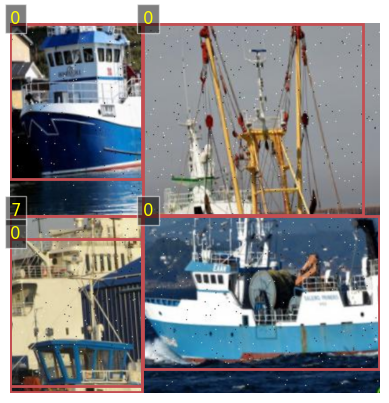

In [35]:
# Visualize an example
example = loaded_data['train'][0]
show_image_with_boxes(example[0], example[1])

In [36]:
# Create simple lists of tuples (image_tensor, label_tensor)
train_data = loaded_data['train']
valid_data = loaded_data['valid']
test_data  = loaded_data['test']

# Use collate_fn so that DataLoader can handle batches with multiple bounding boxes
def collate_fn(batch):
    images, targets = zip(*batch)
    return torch.stack(images), list(targets)

# Create DataLoaders
batch_size = 8

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
test_loader  = DataLoader(test_data,  batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

In [37]:
print("MPS available:", torch.backends.mps.is_available())
print("MPS built:", torch.backends.mps.is_built())

MPS available: False
MPS built: False


In [38]:
# Path to the pretrained model and your data.yaml file
model = YOLO('yolov8n.pt')

# Training
results = model.train(
    data='/content/drive/MyDrive/Colab_Notebooks/rootstrap/data-yolo/data.yaml',
    epochs=200,
    imgsz=640,
    batch=16,
    device='cuda',
    name='yolo-v8-multiboat',
    pretrained=True,
    verbose=True,
    patience=30,
    seed=42,
    val=True,
    save=True,
    close_mosaic=10,
    lr0=3e-4
)


Ultralytics 8.3.152 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/Colab_Notebooks/rootstrap/data-yolo/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=200, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.0003, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolo-v8-multiboat, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=30

100%|██████████| 755k/755k [00:00<00:00, 92.5MB/s]

Overriding model.yaml nc=80 with nc=8

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

Model summary: 129 layers, 3,012,408 parameters, 3,012,392 gradients, 8.2 GFLOPs

Transferred 319/355 items from pretrained weights
Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.4±0.2 ms, read: 27.0±4.0 MB/s, size: 50.3 KB)


train: Scanning /content/drive/MyDrive/Colab_Notebooks/rootstrap/data-yolo/train/labels.cache... 530 images, 0 backgrounds, 0 corrupt: 100%|██████████| 530/530 [00:00<?, ?it/s]

train: /content/drive/MyDrive/Colab_Notebooks/rootstrap/data-yolo/train/images/merch_72_jpg.rf.ae66325da291d31fad88ba41b7123911.jpg: 1 duplicate labels removed
train: /content/drive/MyDrive/Colab_Notebooks/rootstrap/data-yolo/train/images/military_26_jpg.rf.f3ed03aa4401dfbe8ad9540c273e9bed.jpg: 1 duplicate labels removed
train: /content/drive/MyDrive/Colab_Notebooks/rootstrap/data-yolo/train/images/military_36_jpg.rf.027a5b2f6ea7bfad94c48e134b9a998e.jpg: 1 duplicate labels removed
train: /content/drive/MyDrive/Colab_Notebooks/rootstrap/data-yolo/train/images/yacht_34_jpg.rf.23ac82f6c547ecd9fbf14f2ac86bb0ad.jpg: 1 duplicate labels removed


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.5±0.1 ms, read: 12.7±4.9 MB/s, size: 32.5 KB)


val: Scanning /content/drive/MyDrive/Colab_Notebooks/rootstrap/data-yolo/valid/labels.cache... 139 images, 0 backgrounds, 0 corrupt: 100%|██████████| 139/139 [00:00<?, ?it/s]


Plotting labels to runs/detect/yolo-v8-multiboat/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.0003' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000833, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/yolo-v8-multiboat
Starting training for 200 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/200      2.06G      1.028       3.35      1.392         12        640: 100%|██████████| 34/34 [00:05<00:00,  6.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.88it/s]

                   all        139        174    0.00435      0.734     0.0353     0.0155



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/200      2.37G      0.868      2.741      1.311         26        640: 100%|██████████| 34/34 [00:03<00:00,  9.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.31it/s]

                   all        139        174      0.558      0.266       0.27      0.133



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/200      2.37G     0.9083      2.336       1.34         15        640: 100%|██████████| 34/34 [00:03<00:00, 10.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.70it/s]

                   all        139        174      0.296      0.358      0.215     0.0775



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/200      2.37G     0.8655      2.114      1.293         16        640: 100%|██████████| 34/34 [00:03<00:00, 10.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.41it/s]

                   all        139        174      0.549      0.247      0.185     0.0733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/200      2.37G     0.8395      1.921      1.275         16        640: 100%|██████████| 34/34 [00:03<00:00,  9.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.62it/s]

                   all        139        174      0.435       0.48      0.412      0.189



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/200      2.37G     0.8252      1.791      1.259         16        640: 100%|██████████| 34/34 [00:03<00:00, 10.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.77it/s]

                   all        139        174      0.325      0.323      0.242      0.103



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/200      2.37G     0.7831       1.73      1.224         18        640: 100%|██████████| 34/34 [00:03<00:00, 10.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.80it/s]

                   all        139        174      0.366      0.517      0.372      0.174



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/200      2.37G     0.7624      1.613      1.203          8        640: 100%|██████████| 34/34 [00:03<00:00,  9.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.43it/s]

                   all        139        174      0.402      0.406      0.415      0.198



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/200      2.37G     0.7467      1.533      1.192         10        640: 100%|██████████| 34/34 [00:03<00:00, 10.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.03it/s]

                   all        139        174      0.491       0.58      0.522      0.192



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/200      2.37G     0.7178      1.457      1.177         13        640: 100%|██████████| 34/34 [00:03<00:00, 10.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.56it/s]

                   all        139        174      0.499      0.586      0.541      0.273



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/200      2.37G      0.753      1.476      1.211          8        640: 100%|██████████| 34/34 [00:03<00:00, 10.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.89it/s]

                   all        139        174      0.351      0.421      0.426       0.19



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/200      2.37G     0.7259      1.418      1.177         29        640: 100%|██████████| 34/34 [00:03<00:00, 10.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.93it/s]

                   all        139        174      0.538        0.5      0.489      0.228



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/200      2.37G     0.7067      1.406      1.163         31        640: 100%|██████████| 34/34 [00:03<00:00, 10.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.57it/s]

                   all        139        174      0.423       0.43      0.424      0.202



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/200      2.37G     0.7062      1.306      1.153         17        640: 100%|██████████| 34/34 [00:03<00:00, 10.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.81it/s]

                   all        139        174       0.48      0.536      0.485      0.214



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/200      2.37G     0.7016      1.267      1.151         21        640: 100%|██████████| 34/34 [00:03<00:00, 10.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.81it/s]

                   all        139        174      0.544      0.472      0.496      0.221



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/200      2.37G     0.6887       1.27      1.147         11        640: 100%|██████████| 34/34 [00:03<00:00, 10.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.83it/s]

                   all        139        174      0.566       0.53      0.579      0.273



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/200      2.37G     0.6737      1.236      1.147          8        640: 100%|██████████| 34/34 [00:03<00:00, 10.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.64it/s]

                   all        139        174      0.529      0.508      0.524      0.259



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/200      2.38G      0.684      1.293      1.147         10        640: 100%|██████████| 34/34 [00:03<00:00, 10.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.06it/s]

                   all        139        174      0.573      0.638      0.604      0.276



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/200       2.4G     0.6392      1.197      1.108         20        640: 100%|██████████| 34/34 [00:03<00:00, 10.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.77it/s]

                   all        139        174      0.681      0.605      0.603      0.313



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/200      2.42G     0.6515      1.176      1.114         19        640: 100%|██████████| 34/34 [00:03<00:00, 10.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.75it/s]

                   all        139        174      0.624      0.658      0.689      0.354



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/200      2.44G     0.6455      1.132      1.114         11        640: 100%|██████████| 34/34 [00:03<00:00, 10.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.03it/s]

                   all        139        174      0.618      0.592      0.622      0.288



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/200      2.46G     0.6463       1.15      1.111         12        640: 100%|██████████| 34/34 [00:03<00:00,  9.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.13it/s]

                   all        139        174       0.64      0.657      0.646      0.274



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/200      2.47G     0.6402      1.106      1.107         26        640: 100%|██████████| 34/34 [00:03<00:00, 10.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.96it/s]

                   all        139        174      0.643      0.488      0.547      0.258



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/200      2.49G      0.625      1.077      1.097         20        640: 100%|██████████| 34/34 [00:03<00:00, 10.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.08it/s]

                   all        139        174       0.57      0.561      0.551      0.271



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/200      2.51G     0.6199      1.034      1.096         20        640: 100%|██████████| 34/34 [00:03<00:00, 10.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.40it/s]

                   all        139        174      0.674      0.584      0.591      0.254



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/200      2.51G     0.6376      1.094      1.116         15        640: 100%|██████████| 34/34 [00:03<00:00, 10.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.22it/s]

                   all        139        174      0.555      0.548      0.537      0.249



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/200      2.52G     0.6385      1.058      1.106         13        640: 100%|██████████| 34/34 [00:03<00:00, 10.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.80it/s]

                   all        139        174      0.672      0.563      0.614       0.33



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/200      2.52G     0.6354      1.074      1.099         14        640: 100%|██████████| 34/34 [00:03<00:00,  9.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.07it/s]

                   all        139        174      0.507      0.557      0.515      0.219



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/200      2.52G     0.6244      1.034      1.096         18        640: 100%|██████████| 34/34 [00:03<00:00, 10.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.05it/s]

                   all        139        174       0.74      0.601      0.662      0.352



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/200      2.52G     0.6155      1.005      1.082         27        640: 100%|██████████| 34/34 [00:03<00:00, 10.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.89it/s]

                   all        139        174      0.603      0.583      0.616      0.326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/200      2.52G     0.6032      1.006       1.08         29        640: 100%|██████████| 34/34 [00:03<00:00, 10.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.19it/s]

                   all        139        174      0.732      0.621      0.638      0.335



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/200      2.52G     0.6059      1.009      1.087         11        640: 100%|██████████| 34/34 [00:03<00:00, 10.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.03it/s]

                   all        139        174      0.664      0.641      0.673       0.35



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/200      2.52G     0.6124      1.001      1.084         17        640: 100%|██████████| 34/34 [00:03<00:00, 10.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.97it/s]

                   all        139        174      0.708      0.637      0.675      0.349



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/200      2.52G     0.5811     0.9412      1.058         18        640: 100%|██████████| 34/34 [00:03<00:00, 10.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.89it/s]

                   all        139        174      0.658      0.584      0.627       0.32



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/200      2.52G     0.5747     0.9389      1.071         18        640: 100%|██████████| 34/34 [00:03<00:00, 10.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.21it/s]

                   all        139        174      0.746      0.606       0.64      0.289



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/200      2.52G     0.5912     0.9325      1.069         20        640: 100%|██████████| 34/34 [00:03<00:00,  9.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.69it/s]

                   all        139        174      0.785      0.692      0.741      0.356



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/200      2.52G     0.6007     0.9578        1.1         11        640: 100%|██████████| 34/34 [00:03<00:00, 10.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.25it/s]

                   all        139        174      0.772      0.647      0.719      0.349



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/200      2.52G     0.5828     0.9481      1.081         25        640: 100%|██████████| 34/34 [00:03<00:00, 10.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.34it/s]

                   all        139        174      0.689      0.601      0.689      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/200      2.52G     0.5798     0.9055      1.051         15        640: 100%|██████████| 34/34 [00:03<00:00, 10.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.81it/s]

                   all        139        174      0.764       0.57      0.624      0.273



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/200      2.52G     0.5877     0.9165      1.068         12        640: 100%|██████████| 34/34 [00:03<00:00, 10.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.42it/s]

                   all        139        174      0.696      0.604      0.662      0.364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/200      2.52G     0.5781     0.9035      1.072         10        640: 100%|██████████| 34/34 [00:03<00:00, 10.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.15it/s]

                   all        139        174       0.72      0.669      0.703      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/200      2.52G     0.5721     0.9109       1.07         11        640: 100%|██████████| 34/34 [00:03<00:00,  9.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.92it/s]

                   all        139        174      0.659      0.526      0.599      0.314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/200      2.52G     0.5823      0.918      1.069         12        640: 100%|██████████| 34/34 [00:03<00:00, 10.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.96it/s]

                   all        139        174      0.709       0.59      0.639      0.324



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/200      2.52G     0.5635     0.9244      1.056          8        640: 100%|██████████| 34/34 [00:03<00:00, 10.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.58it/s]

                   all        139        174      0.813      0.612      0.718      0.311



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/200      2.52G     0.5652     0.8606      1.053         13        640: 100%|██████████| 34/34 [00:03<00:00,  9.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.15it/s]

                   all        139        174      0.722      0.629      0.638      0.291



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/200      2.52G     0.5556     0.8646      1.048          8        640: 100%|██████████| 34/34 [00:03<00:00,  9.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.13it/s]

                   all        139        174      0.633      0.656      0.676      0.341



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/200      2.52G     0.5594     0.8598      1.056         23        640: 100%|██████████| 34/34 [00:03<00:00, 10.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.07it/s]

                   all        139        174      0.686      0.693      0.699      0.362



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/200      2.52G     0.5493     0.8479      1.042         25        640: 100%|██████████| 34/34 [00:03<00:00, 10.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.55it/s]

                   all        139        174      0.783      0.627      0.693      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/200      2.52G     0.5508     0.8312      1.049         16        640: 100%|██████████| 34/34 [00:03<00:00, 10.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.12it/s]

                   all        139        174      0.697      0.528      0.595      0.269



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/200      2.52G     0.5578     0.8334      1.048         24        640: 100%|██████████| 34/34 [00:03<00:00, 10.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.09it/s]

                   all        139        174      0.598      0.728      0.708      0.361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/200      2.52G     0.5333     0.8039       1.04         26        640: 100%|██████████| 34/34 [00:03<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.07it/s]

                   all        139        174      0.582        0.6      0.606      0.302



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/200      2.52G     0.5329     0.7997      1.043         12        640: 100%|██████████| 34/34 [00:03<00:00, 10.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.13it/s]

                   all        139        174      0.578       0.71       0.66      0.298



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/200      2.52G     0.5481     0.8332      1.046          8        640: 100%|██████████| 34/34 [00:03<00:00, 10.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.38it/s]

                   all        139        174      0.768      0.632      0.702      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/200      2.52G     0.5365     0.7882      1.039         29        640: 100%|██████████| 34/34 [00:03<00:00,  9.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.31it/s]

                   all        139        174      0.776      0.624        0.7      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/200      2.52G     0.5414     0.8091      1.052         12        640: 100%|██████████| 34/34 [00:03<00:00, 10.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.57it/s]

                   all        139        174      0.661      0.671      0.686      0.368



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/200      2.52G     0.5405      0.793       1.04         22        640: 100%|██████████| 34/34 [00:03<00:00, 10.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.94it/s]

                   all        139        174      0.726      0.658      0.702      0.315



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/200      2.52G     0.5228     0.7532      1.047         11        640: 100%|██████████| 34/34 [00:03<00:00, 10.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.11it/s]

                   all        139        174      0.805      0.691      0.747      0.339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/200      2.52G     0.5102     0.7754      1.021         24        640: 100%|██████████| 34/34 [00:03<00:00,  9.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.36it/s]

                   all        139        174      0.709      0.724      0.711      0.353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/200      2.52G     0.5092     0.7577      1.036         13        640: 100%|██████████| 34/34 [00:03<00:00, 10.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.85it/s]

                   all        139        174      0.835      0.633      0.715      0.335



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/200      2.52G      0.518     0.7652      1.033         10        640: 100%|██████████| 34/34 [00:03<00:00, 10.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.21it/s]

                   all        139        174      0.746      0.761       0.77      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/200      2.52G     0.5222      0.775      1.029          9        640: 100%|██████████| 34/34 [00:03<00:00, 10.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.17it/s]

                   all        139        174      0.757      0.728      0.734      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/200      2.52G     0.5111     0.7515      1.023         13        640: 100%|██████████| 34/34 [00:03<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.38it/s]

                   all        139        174      0.688      0.613      0.632        0.3



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/200      2.52G     0.5195      0.737      1.029         22        640: 100%|██████████| 34/34 [00:03<00:00, 10.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.39it/s]

                   all        139        174      0.709      0.622      0.702      0.349



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/200      2.52G     0.5161     0.7531      1.029         16        640: 100%|██████████| 34/34 [00:03<00:00, 10.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.26it/s]

                   all        139        174      0.737      0.617      0.671      0.311



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/200      2.52G     0.5227     0.7654       1.03         16        640: 100%|██████████| 34/34 [00:03<00:00, 10.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.35it/s]

                   all        139        174      0.718      0.739      0.732      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/200      2.52G     0.5003     0.7295      1.015         17        640: 100%|██████████| 34/34 [00:03<00:00,  9.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.34it/s]

                   all        139        174      0.783      0.703      0.724      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/200      2.52G     0.5197     0.7404      1.024         13        640: 100%|██████████| 34/34 [00:03<00:00, 10.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.22it/s]

                   all        139        174      0.824       0.68      0.737      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/200      2.52G      0.499     0.7044      1.011         18        640: 100%|██████████| 34/34 [00:03<00:00,  9.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.69it/s]

                   all        139        174      0.767      0.678       0.73      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/200      2.52G     0.4997     0.7181      1.024         14        640: 100%|██████████| 34/34 [00:03<00:00, 10.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.04it/s]

                   all        139        174      0.722      0.656      0.703      0.355



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/200      2.52G      0.509     0.7117      1.025         17        640: 100%|██████████| 34/34 [00:03<00:00, 10.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.33it/s]

                   all        139        174      0.853      0.636      0.727      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/200      2.52G     0.4891     0.7038      1.024         12        640: 100%|██████████| 34/34 [00:03<00:00, 10.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.47it/s]

                   all        139        174      0.654      0.698      0.691      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/200      2.52G     0.4925     0.6692      1.009         14        640: 100%|██████████| 34/34 [00:03<00:00, 10.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.99it/s]

                   all        139        174      0.688       0.78      0.734      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/200      2.52G     0.4921     0.6792      1.004         25        640: 100%|██████████| 34/34 [00:03<00:00, 10.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.02it/s]

                   all        139        174      0.837      0.696      0.759      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/200      2.52G     0.4993     0.6876      1.012         14        640: 100%|██████████| 34/34 [00:03<00:00, 10.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.28it/s]

                   all        139        174      0.636      0.712      0.706      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/200      2.52G     0.4877     0.6663      1.007         23        640: 100%|██████████| 34/34 [00:03<00:00, 10.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.58it/s]

                   all        139        174      0.725       0.68      0.703      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/200      2.52G     0.4721     0.6669          1         16        640: 100%|██████████| 34/34 [00:03<00:00, 10.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.38it/s]

                   all        139        174      0.819      0.701      0.758      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/200      2.52G     0.4888     0.6781      1.009         13        640: 100%|██████████| 34/34 [00:03<00:00, 10.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.55it/s]

                   all        139        174      0.648      0.724      0.722        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/200      2.52G     0.4873     0.6704      1.012         12        640: 100%|██████████| 34/34 [00:03<00:00, 10.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.22it/s]

                   all        139        174      0.737      0.661      0.708      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/200      2.52G     0.4772     0.6475     0.9925         13        640: 100%|██████████| 34/34 [00:03<00:00,  9.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.32it/s]

                   all        139        174      0.836       0.69      0.791      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/200      2.52G     0.4749     0.6511      1.005          9        640: 100%|██████████| 34/34 [00:03<00:00,  9.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.57it/s]

                   all        139        174      0.695      0.643      0.683      0.353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/200      2.52G     0.4724     0.6826      1.003         18        640: 100%|██████████| 34/34 [00:03<00:00, 10.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.68it/s]

                   all        139        174      0.792       0.66      0.712      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/200      2.52G     0.4716     0.6607      1.004         19        640: 100%|██████████| 34/34 [00:03<00:00,  9.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.19it/s]

                   all        139        174      0.725       0.65      0.714      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/200      2.52G     0.4777     0.6792      1.011          8        640: 100%|██████████| 34/34 [00:03<00:00, 10.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.96it/s]

                   all        139        174      0.712      0.691      0.732      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/200      2.52G     0.4577      0.634     0.9893         19        640: 100%|██████████| 34/34 [00:03<00:00, 10.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.49it/s]

                   all        139        174      0.827      0.715      0.784       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/200      2.52G     0.4646     0.6654     0.9966          9        640: 100%|██████████| 34/34 [00:03<00:00,  9.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.29it/s]

                   all        139        174      0.618      0.686      0.668      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/200      2.52G     0.4689     0.6304     0.9979         21        640: 100%|██████████| 34/34 [00:03<00:00, 10.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.47it/s]

                   all        139        174      0.679      0.719      0.689      0.354



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/200      2.52G       0.47     0.6419      1.001         12        640: 100%|██████████| 34/34 [00:03<00:00, 10.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.36it/s]

                   all        139        174      0.868      0.731      0.787      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/200      2.52G     0.4762     0.6879       1.01          9        640: 100%|██████████| 34/34 [00:03<00:00,  9.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.73it/s]

                   all        139        174      0.892      0.771       0.83      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/200      2.52G     0.4877     0.6188      1.006          9        640: 100%|██████████| 34/34 [00:03<00:00, 10.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.29it/s]

                   all        139        174      0.866      0.704      0.784      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/200      2.52G     0.4585     0.6301     0.9912         18        640: 100%|██████████| 34/34 [00:03<00:00, 10.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.21it/s]

                   all        139        174      0.823       0.73      0.778      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/200      2.52G     0.4495     0.6301     0.9936         12        640: 100%|██████████| 34/34 [00:03<00:00,  9.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.46it/s]

                   all        139        174      0.747      0.673      0.719      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/200      2.52G     0.4701     0.6284     0.9929         23        640: 100%|██████████| 34/34 [00:03<00:00, 10.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.53it/s]

                   all        139        174      0.742      0.697      0.741      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/200      2.52G     0.4417     0.6085     0.9948         13        640: 100%|██████████| 34/34 [00:03<00:00, 10.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.65it/s]

                   all        139        174      0.823      0.685      0.772      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/200      2.52G     0.4471     0.5968     0.9812         18        640: 100%|██████████| 34/34 [00:03<00:00,  9.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.51it/s]

                   all        139        174      0.819      0.665      0.759      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/200      2.52G      0.449     0.5992     0.9841          8        640: 100%|██████████| 34/34 [00:03<00:00, 10.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.40it/s]

                   all        139        174       0.78      0.693      0.768      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/200      2.52G     0.4814     0.6495      1.029          6        640: 100%|██████████| 34/34 [00:03<00:00,  9.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.33it/s]

                   all        139        174      0.802      0.756      0.778      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/200      2.52G     0.4291     0.5794     0.9783         14        640: 100%|██████████| 34/34 [00:03<00:00,  9.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.56it/s]

                   all        139        174      0.755      0.711       0.73      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/200      2.52G      0.452     0.6132     0.9917         17        640: 100%|██████████| 34/34 [00:03<00:00, 10.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.19it/s]

                   all        139        174       0.78      0.739      0.776       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/200      2.52G     0.4455     0.5977     0.9923         29        640: 100%|██████████| 34/34 [00:03<00:00, 10.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.29it/s]

                   all        139        174      0.861      0.656      0.779      0.359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/200      2.52G     0.4451     0.5899     0.9846         19        640: 100%|██████████| 34/34 [00:03<00:00,  9.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.29it/s]

                   all        139        174      0.783      0.711      0.746      0.367



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/200      2.52G       0.45     0.5896     0.9953         16        640: 100%|██████████| 34/34 [00:03<00:00, 10.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.41it/s]

                   all        139        174      0.806      0.777      0.803      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/200      2.52G     0.4449     0.6035     0.9821         16        640: 100%|██████████| 34/34 [00:03<00:00, 10.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.31it/s]

                   all        139        174      0.728      0.777      0.771      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/200      2.52G     0.4255     0.5726     0.9715         16        640: 100%|██████████| 34/34 [00:03<00:00, 10.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.59it/s]

                   all        139        174      0.749      0.764      0.757      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/200      2.52G      0.438     0.5776     0.9887         16        640: 100%|██████████| 34/34 [00:03<00:00, 10.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.57it/s]

                   all        139        174      0.789      0.761      0.741      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/200      2.52G     0.4303     0.5612     0.9759         18        640: 100%|██████████| 34/34 [00:03<00:00, 10.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.21it/s]

                   all        139        174      0.703      0.786      0.764      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/200      2.52G     0.4268     0.5635     0.9713         18        640: 100%|██████████| 34/34 [00:03<00:00,  9.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.44it/s]

                   all        139        174      0.829      0.676      0.749      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/200      2.52G     0.4208     0.5474     0.9694         22        640: 100%|██████████| 34/34 [00:03<00:00, 10.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.13it/s]

                   all        139        174      0.742      0.723      0.741      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/200      2.52G      0.437     0.5832     0.9871          8        640: 100%|██████████| 34/34 [00:03<00:00, 10.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.10it/s]

                   all        139        174      0.716      0.751      0.761      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/200      2.52G     0.4277     0.5647     0.9843         16        640: 100%|██████████| 34/34 [00:03<00:00, 10.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.20it/s]

                   all        139        174       0.81      0.742      0.763      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/200      2.52G     0.4205     0.5619     0.9709          8        640: 100%|██████████| 34/34 [00:03<00:00, 10.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.55it/s]

                   all        139        174      0.752      0.721      0.752      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/200      2.52G     0.4322      0.583     0.9791         18        640: 100%|██████████| 34/34 [00:03<00:00, 10.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.10it/s]

                   all        139        174      0.641      0.768      0.716      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/200      2.52G      0.442     0.5813     0.9937         10        640: 100%|██████████| 34/34 [00:03<00:00, 10.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.21it/s]

                   all        139        174      0.776      0.734      0.767      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/200      2.52G      0.419     0.5275      0.972         22        640: 100%|██████████| 34/34 [00:03<00:00, 10.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.11it/s]

                   all        139        174      0.816      0.724      0.772      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/200      2.52G     0.4191     0.5371     0.9711         22        640: 100%|██████████| 34/34 [00:03<00:00,  9.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.29it/s]

                   all        139        174      0.755      0.743      0.752      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/200      2.52G     0.4241     0.5475     0.9702         19        640: 100%|██████████| 34/34 [00:03<00:00, 10.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.14it/s]

                   all        139        174      0.731        0.7      0.752      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/200      2.52G     0.4076     0.5311      0.966         14        640: 100%|██████████| 34/34 [00:03<00:00, 10.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.32it/s]

                   all        139        174      0.727      0.709      0.709      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/200      2.52G     0.4106     0.5219     0.9671         15        640: 100%|██████████| 34/34 [00:03<00:00,  9.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.68it/s]

                   all        139        174      0.727      0.721      0.713      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/200      2.52G     0.4115     0.5375     0.9594         23        640: 100%|██████████| 34/34 [00:03<00:00, 10.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.45it/s]

                   all        139        174      0.733      0.726      0.742       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/200      2.52G     0.4201     0.5474     0.9842          8        640: 100%|██████████| 34/34 [00:03<00:00, 10.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.64it/s]

                   all        139        174      0.836      0.741      0.796      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/200      2.52G     0.4131     0.5603     0.9714         19        640: 100%|██████████| 34/34 [00:03<00:00,  9.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.20it/s]

                   all        139        174       0.74      0.693      0.756      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/200      2.52G      0.406     0.5287     0.9701         17        640: 100%|██████████| 34/34 [00:03<00:00, 10.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.33it/s]

                   all        139        174      0.739       0.79      0.777      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/200      2.52G      0.415     0.5326     0.9574         15        640: 100%|██████████| 34/34 [00:03<00:00, 10.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.08it/s]

                   all        139        174      0.854       0.71      0.766      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/200      2.52G     0.3993     0.5407     0.9603         18        640: 100%|██████████| 34/34 [00:03<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.27it/s]

                   all        139        174      0.748      0.763      0.741      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/200      2.52G     0.4176     0.5399      0.966         10        640: 100%|██████████| 34/34 [00:03<00:00, 10.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.73it/s]

                   all        139        174      0.756      0.765      0.794      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/200      2.52G     0.4161     0.5263     0.9716         11        640: 100%|██████████| 34/34 [00:03<00:00, 10.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.47it/s]

                   all        139        174      0.823      0.724      0.791      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/200      2.52G     0.4006     0.5336     0.9669         21        640: 100%|██████████| 34/34 [00:03<00:00,  9.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.32it/s]

                   all        139        174       0.79      0.795      0.797      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/200      2.52G     0.3988     0.5096     0.9597         20        640: 100%|██████████| 34/34 [00:03<00:00, 10.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.78it/s]

                   all        139        174      0.798      0.747      0.801       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/200      2.52G     0.3964     0.4904     0.9597         16        640: 100%|██████████| 34/34 [00:03<00:00, 10.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.01it/s]

                   all        139        174      0.795       0.76      0.788      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/200      2.52G     0.3866     0.5025     0.9564         21        640: 100%|██████████| 34/34 [00:03<00:00,  9.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.66it/s]

                   all        139        174      0.864      0.762      0.821      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/200      2.52G     0.4017     0.5127     0.9596         13        640: 100%|██████████| 34/34 [00:03<00:00, 10.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.52it/s]

                   all        139        174      0.794      0.773      0.804       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/200      2.52G     0.3957     0.4952     0.9495         16        640: 100%|██████████| 34/34 [00:03<00:00, 10.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.13it/s]

                   all        139        174      0.796      0.791      0.808      0.443
EarlyStopping: Training stopped early as no improvement observed in last 30 epochs. Best results observed at epoch 101, best model saved as best.pt.
To update EarlyStopping(patience=30) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



131 epochs completed in 0.160 hours.
Optimizer stripped from runs/detect/yolo-v8-multiboat/weights/last.pt, 6.3MB
Optimizer stripped from runs/detect/yolo-v8-multiboat/weights/best.pt, 6.3MB

Validating runs/detect/yolo-v8-multiboat/weights/best.pt...
Ultralytics 8.3.152 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
Model summary (fused): 72 layers, 3,007,208 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.37it/s]


                   all        139        174      0.806      0.777      0.802      0.487
          Fishing Boat         24         29      0.839      0.899      0.949       0.63
         Merchant Ship         22         24      0.896       0.75      0.851      0.491
         Military Ship         21         24       0.98       0.75      0.851      0.563
           Patrol Boat         25         28      0.873      0.492      0.544      0.289
            Sails Boat         27         35      0.831      0.657      0.698      0.384
             Submarine         15         15      0.928          1      0.991      0.594
               Tugboat          3          3      0.245      0.667      0.556      0.235
                 Yacht         16         16      0.855          1      0.981      0.715
Speed: 0.2ms preprocess, 1.0ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to runs/detect/yolo-v8-multiboat


## 3. Results and Final Comments

### 3.1 Confusion Matrix

In [39]:
### Function to display a list of images one by one from a specified directory

def display_images(post_training_files_path, image_files):
    for image_file in image_files:
        image_path = os.path.join(post_training_files_path, image_file)
        img = cv2.imread(image_path)

        if img is None:
            print(f"❌ Could not load image: {image_path}")
            continue

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.figure(figsize=(10, 10), dpi=120)
        plt.imshow(img)
        plt.axis('off')
        plt.title(image_file)
        plt.show()


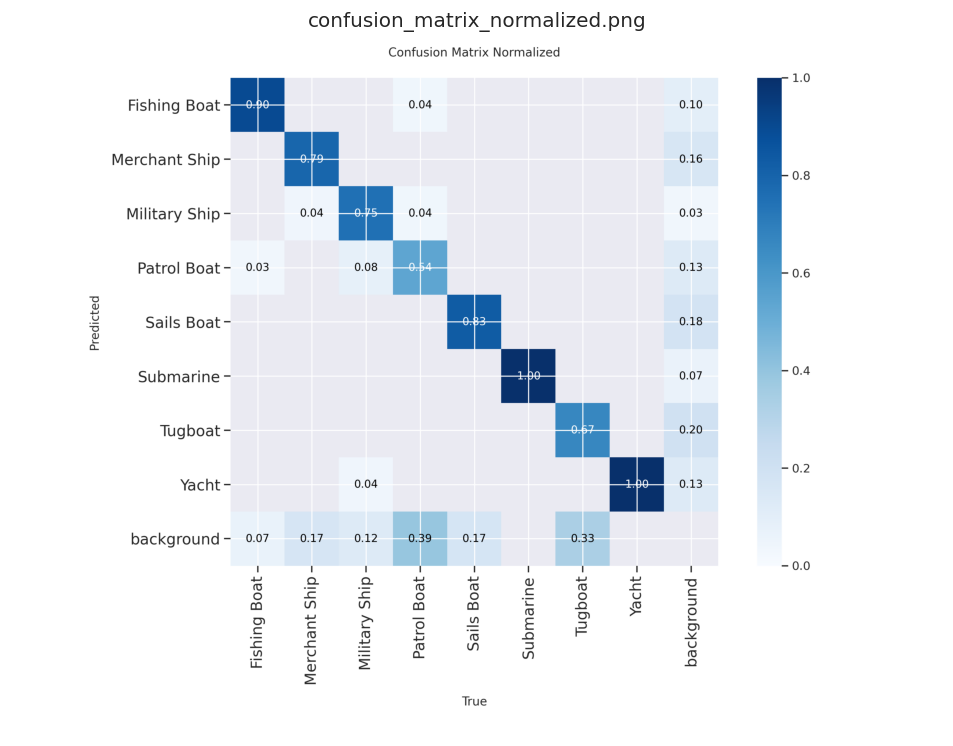

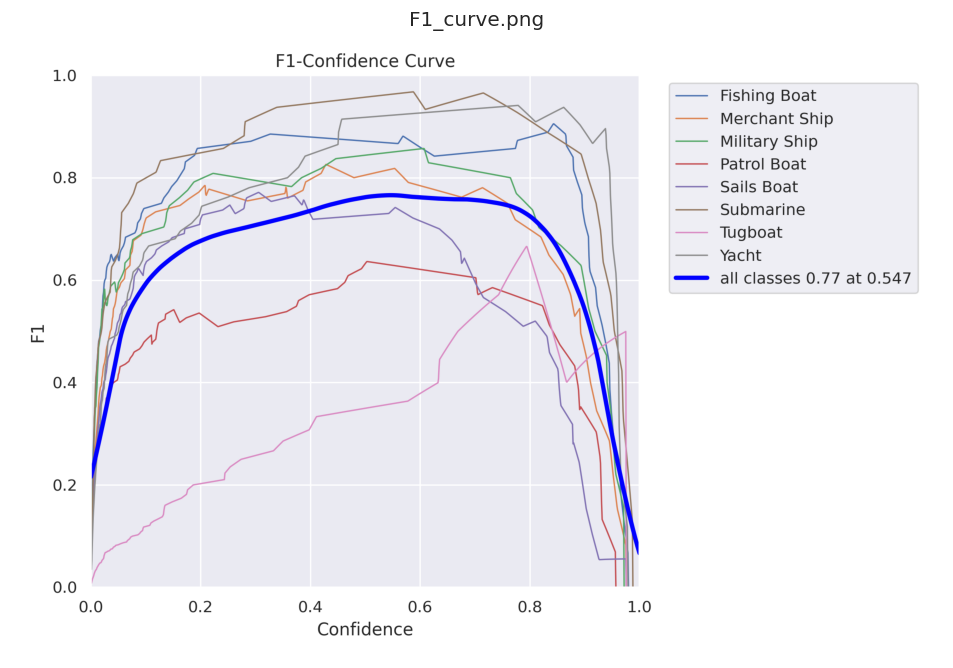

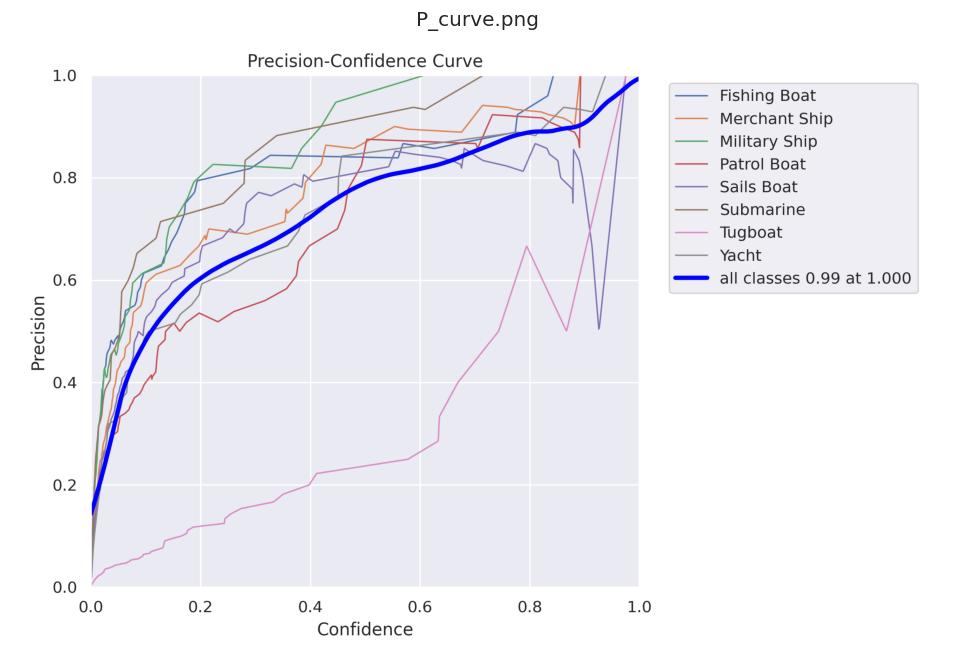

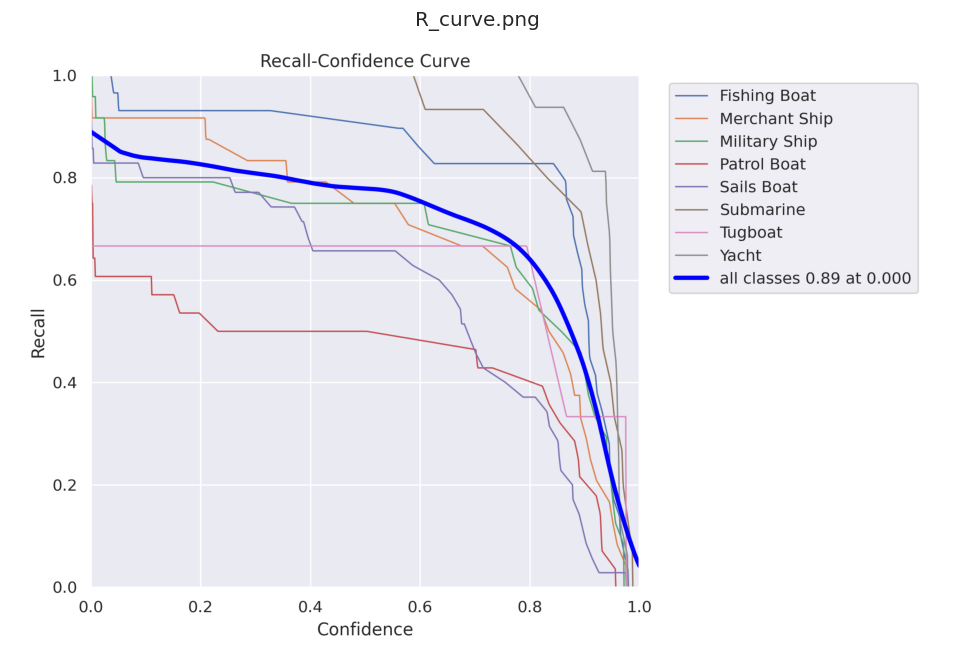

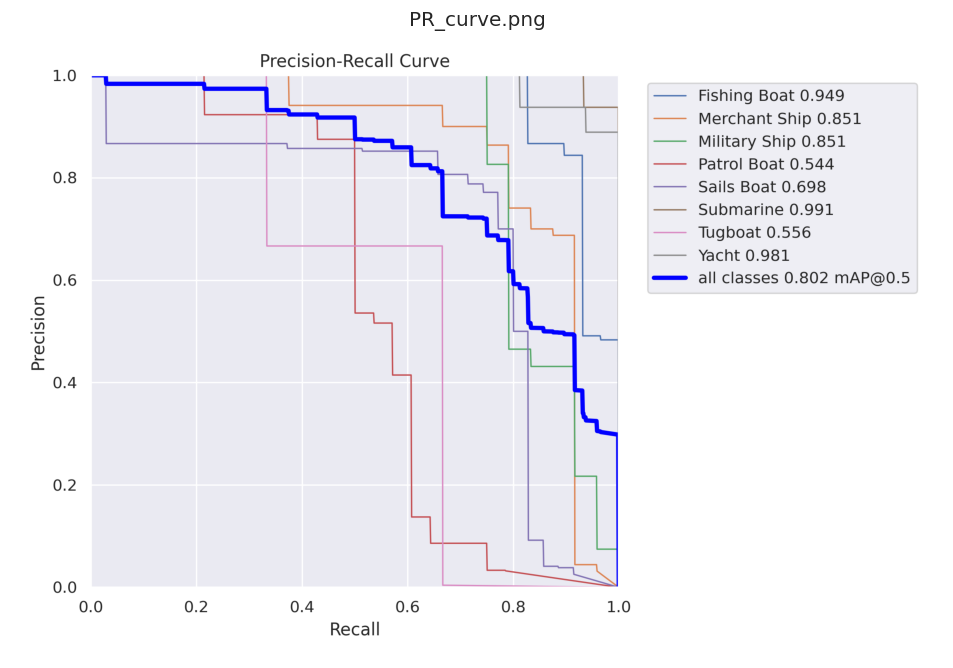

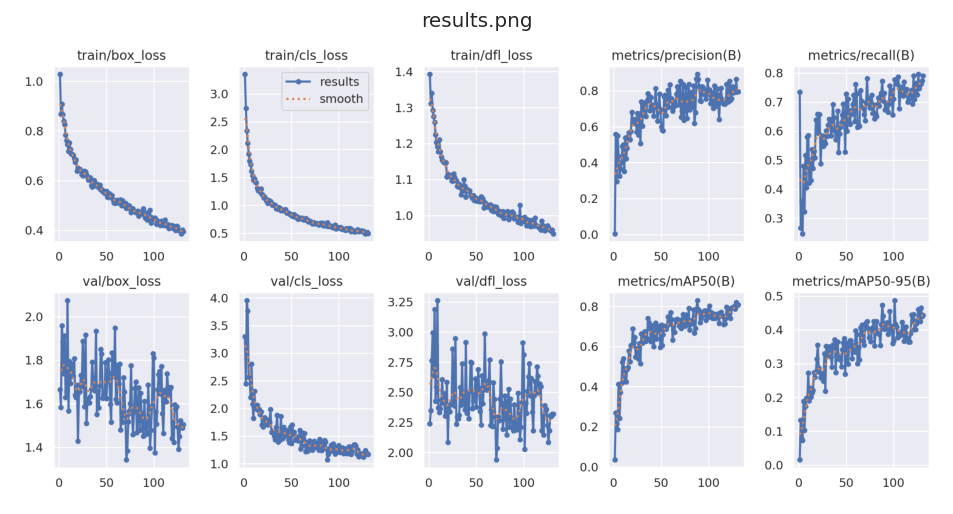

In [40]:
# List of image files to display
image_files = [
    'confusion_matrix_normalized.png',
    'F1_curve.png',
    'P_curve.png',
    'R_curve.png',
    'PR_curve.png',
    'results.png'
]

# Path to the directory containing the images
post_training_files_path = '/content/drive/MyDrive/Colab_Notebooks/rootstrap/runs/detect/yolo-v8-multiboat'

# Display the images
display_images(post_training_files_path, image_files)

Hay dos opciones:

- Maximizar Recall: quiero que la mayoria sean TP ... seguridad, vigilancia, enfermedades.
- Maximizar Precisión: tolero más FP .. ej, sistemas de alertas temprana, controles de calidad...etc
Muchos Falsos Negativos --> Bajo Recall

### 3.2 Predict with Test Sample

In [8]:
# 1. Cargar modelo entrenado
model = YOLO('runs/detect/yolo-v8-multiboat/weights/best.pt')

# 2. Ruta de imágenes de test
test_images_path = '/content/drive/MyDrive/Colab_Notebooks/rootstrap/data-yolo/test/images'
image_paths = [os.path.join(test_images_path, f) for f in os.listdir(test_images_path) if f.endswith('.jpg')]

# 3. Mapas de clases
class_map = model.names  # {0: 'boat', 1: 'cargo', etc.}
labels = list(class_map.keys())
display_labels = list(class_map.values()) + ["No prediction"]  # Agregamos 'No prediction'

# 4. Iniciar listas
y_true = []
y_pred = []

# 5. Iterar por imágenes
for img_path in image_paths:
    label_path = img_path.replace('/images/', '/labels/').replace('.jpg', '.txt')

    # Leer etiquetas verdaderas
    try:
        with open(label_path, 'r') as f:
            gt_classes = [int(line.strip().split()[0]) for line in f.readlines()]
    except FileNotFoundError:
        continue

    # Inferir con el modelo
    result = model(img_path, conf=0.25, iou=0.5)[0]
    pred_classes = result.boxes.cls.cpu().numpy().astype(int) if result.boxes else []

    # Asumimos una sola clase (simplificado)
    y_true.append(gt_classes[0])
    if len(pred_classes) > 0:
        y_pred.append(pred_classes[0])
    else:
        y_pred.append(len(class_map))  # índice artificial para "No prediction"



image 1/1 /content/drive/MyDrive/Colab_Notebooks/rootstrap/data-yolo/test/images/fish_1_jpg.rf.3d78a162e23dd349a3ed5a5aa3bd1589.jpg: 640x640 1 Fishing Boat, 7.6ms
Speed: 15.5ms preprocess, 7.6ms inference, 304.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/drive/MyDrive/Colab_Notebooks/rootstrap/data-yolo/test/images/fish_4_jpg.rf.488acb99267cb4625ea045a086085528.jpg: 640x640 1 Fishing Boat, 8.6ms
Speed: 3.9ms preprocess, 8.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/drive/MyDrive/Colab_Notebooks/rootstrap/data-yolo/test/images/fish_18_jpg.rf.6a3b197fb12bce9e1f7f6bdd7294d211.jpg: 640x640 1 Fishing Boat, 10.3ms
Speed: 2.9ms preprocess, 10.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/drive/MyDrive/Colab_Notebooks/rootstrap/data-yolo/test/images/fish_19_jpg.rf.fee7a444ea822fffbaef8e50c7310e85.jpg: 640x640 1 Fishing Boat, 7.7ms
Speed: 2.8ms preprocess, 7.7ms inference, 1.7ms p

Ultralytics 8.3.152 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
Model summary (fused): 72 layers, 3,007,208 parameters, 0 gradients, 8.1 GFLOPs


100%|██████████| 755k/755k [00:00<00:00, 27.9MB/s]

val: Fast image access ✅ (ping: 0.4±0.1 ms, read: 26.2±4.8 MB/s, size: 30.0 KB)



val: Scanning /content/drive/MyDrive/Colab_Notebooks/rootstrap/data-yolo/test/labels.cache... 67 images, 0 backgrounds, 0 corrupt: 100%|██████████| 67/67 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.74it/s]


                   all         67         90      0.884      0.763      0.881      0.548
          Fishing Boat          8          9      0.875      0.889      0.917       0.62
         Merchant Ship          7          7       0.72      0.857      0.904       0.61
         Military Ship          9          9      0.963      0.778      0.943      0.628
           Patrol Boat         13         15          1      0.483      0.763       0.35
            Sails Boat         18         30      0.928       0.43      0.737       0.37
             Submarine          8          8          1      0.943      0.995      0.532
               Tugboat          1          1      0.588          1      0.995      0.796
                 Yacht         11         11          1      0.722      0.797      0.476
Speed: 2.8ms preprocess, 5.7ms inference, 0.0ms loss, 6.4ms postprocess per image
Results saved to runs/detect/val2


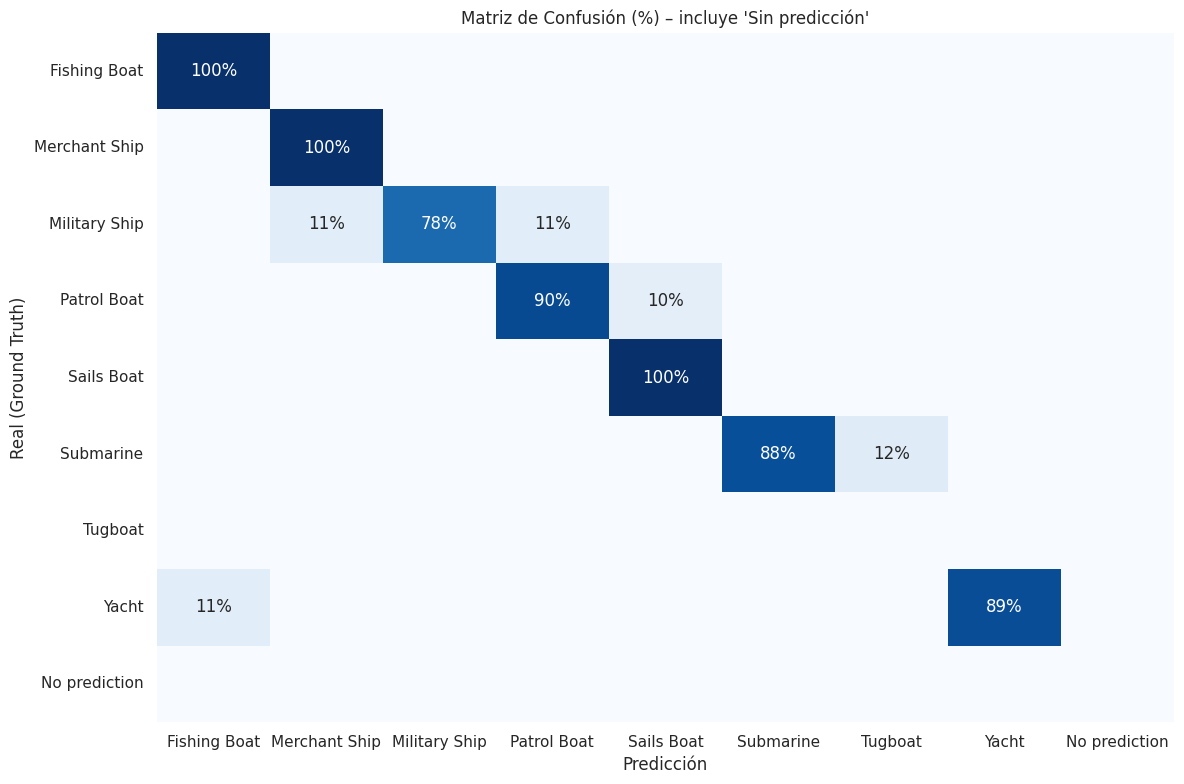

In [14]:
# Load the trained model (the best one according to validation)
model = YOLO('runs/detect/yolo-v8-multiboat/weights/best.pt')

# Evaluate on the TEST set
metrics = model.val(
    data='/content/drive/MyDrive/Colab_Notebooks/rootstrap/data-yolo/data.yaml',
    split='test'
)

# Matriz de confusión extendida
labels_extended = labels + [len(class_map)]  # incluye "No prediction" como última clase
cm = confusion_matrix(y_true, y_pred, labels=labels_extended)

# Convertir a porcentaje por fila (ground truth)
row_sums = cm.sum(axis=1, keepdims=True)
cm_perc = np.divide(cm, row_sums, where=row_sums != 0) * 100
cm_perc = np.round(cm_perc).astype(int)

# Etiquetas de celdas con %
cm_str = np.vectorize(lambda x: f"{x}%" if x > 0 else "")(cm_perc)

# Visualización con seaborn
fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(cm_perc, annot=cm_str, fmt="", cmap="Blues",
            xticklabels=display_labels, yticklabels=display_labels,
            cbar=False, ax=ax)

ax.set_xlabel("Predicción")
ax.set_ylabel("Real (Ground Truth)")
plt.title("Matriz de Confusión (%) – incluye 'Sin predicción'")
plt.tight_layout()
plt.show()
